[!toc]

# Advanced Model 
Gradient boosting decision tree

In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,roc_curve, auc, plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.utils import resample
from sklearn import preprocessing

In [2]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [3]:
from feature_selection.feature_selection import feature_selection, feature_selection_for_detection
from splitter import splitter

In [4]:
pred_path = "../files/SeizurePrediction/"
dect_path = "../files/SeizureDetection/"

## Prediction

### Feature Selection

In [4]:
file_list = list(Path(pred_path).glob("*.csv"))
samples = [f.name.split('.')[0] for f in file_list]

In [5]:
file_list[0].parent

WindowsPath('../files/SeizurePrediction')

In [6]:
res = pd.DataFrame(data_x)
res["result"] = data_y
res

NameError: name 'data_x' is not defined

In [16]:
file_list = [f for f in Path(dect_path).glob("*atient*.csv") if "reduced" not in f.name]
for f in file_list:
    # data = pd.read_csv(f.resolve(), header=None)
    sample = f.name.split('.')[0]
    print('='*10,sample,'='*10)
    data_x,data_y = feature_selection_for_detection(f.resolve())
    res = pd.DataFrame(data_x)
    res["result"] = data_y
    res.to_csv(os.path.join(f.parent.resolve(), sample+"_reduced.csv"), index=False)

========== Patient_1 ==========
Number of Observation(raw): 1044
Number of features(raw): 1905
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_2 ==========
Number of Observation(raw): 3141
Number of features(raw): 449
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_3 ==========
Number of Observation(raw): 1041
Number of features(raw): 1541
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_4 ==========
Number of Observation(raw): 210
Number of features(raw): 2017
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_5 ==========
Number of Observation(raw): 2745
Number of features(raw): 1793
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_6 ==========
Number of Observation(raw): 2997
Number of features(raw): 841
Fitting 5 folds for each of 20 candidates, totalling 100 fits
========== Patient_7 ==========
Number of Observation(raw): 3

In [ ]:
file_list = list(Path(pred_path).glob("*.csv"))
for f in file_list:
    # data = pd.read_csv(f.resolve(), header=None)
    sample = f.name.split('.')[0]
    print('='*10,sample,'='*10)
    data_x,data_y = feature_selection(f.resolve())
    res = pd.DataFrame(data_x)
    res["result"] = data_y
    res.to_csv(os.path.join(f.parent.resolve(), sample+"_reduced.csv"), index=False)

### balance data

In [5]:
def balance_data(data_x, data_y,verbose=False):
    if verbose: print('Original dataset shape %s' % Counter(data_y))
    sm = SMOTE()
    X_res, y_res = sm.fit_resample(data_x, data_y)
    if verbose: print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

def scale_data(x):
    train_scaler = preprocessing.StandardScaler().fit(x)
    return train_scaler.transform(x)


### gbdt

In [6]:
def print_statistics(y_test, y_pred,i=None):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    PPV = tp / (tp+fp)
    f1 =  2*((PPV*sensitivity)/(PPV+sensitivity))
    print("{:^5d},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f},{:^15.4f}".format(i,specificity,sensitivity,accuracy,PPV,f1))

def train_pred(X, y, save=False):
    cv = StratifiedKFold(5,shuffle = True, random_state=2021534)
    tprs = []
    aucs = []
    
    originalclass = []
    predictedclass = []

    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(8,6))
    print("{:^5s},{:^15s},{:^15s},{:^15s},{:^15s},{:^15s}".format("fold","specificity","sensitivity",'accuracy','PPV','f1'))
    for i, (train, test) in enumerate(cv.split(X, y)):
        X_train, y_train = balance_data(X[train], y[train])
        scaler = preprocessing.StandardScaler().fit(X[train])
        X_train = scaler.transform(X_train)
        X_test, y_test = X[test], y[test]
        X_test = scaler.transform(X_test)
        gradient_boosting = GradientBoostingClassifier(n_estimators=200,max_features='log2',random_state=2021).fit(X_train, y_train)
#         y_pred = gradient_boosting.predict(X_test)
                
        y_hat = gradient_boosting.predict_proba(X_test)[:, 1]
        # Calculate the ROC Curves
        fpr, tpr, thresholds = roc_curve(y_test, y_hat)
        gmeans = np.sqrt(tpr * (1-fpr))
        
        ix = np.argmax(gmeans)
        y_pred = gradient_boosting.predict_proba(X_test)[:,1] >= thresholds[ix]
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', alpha=0.3)
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)
        
        viz = plot_roc_curve(gradient_boosting, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        # basic statistics
        print_statistics(y_test, y_pred,i)
        print_statistics(y_test, gradient_boosting.predict(X_test),i)
        
    print(classification_report(originalclass, predictedclass))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.legend(loc="lower right")
    if save:
        plt.savefig(os.path.join("./figures", "gbdt_rocaoc_pred_{}.pdf".format(save)))
    plt.show()
    return aucs


In [7]:
# aucs = train_pred(data_x, data_y)

## main

========== Dog_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.6191     ,    0.8846     ,    0.6320     ,    0.1055     ,    0.1885     
  0  ,    0.9434     ,    0.3077     ,    0.9126     ,    0.2162     ,    0.2540     
  1  ,    0.5547     ,    0.7308     ,    0.5632     ,    0.0769     ,    0.1392     
  1  ,    0.9453     ,    0.2308     ,    0.9108     ,    0.1765     ,    0.2000     
  2  ,    0.7695     ,    0.6154     ,    0.7621     ,    0.1194     ,    0.2000     
  2  ,    0.9258     ,    0.4231     ,    0.9015     ,    0.2245     ,    0.2933     
  3  ,    0.6621     ,    0.6400     ,    0.6611     ,    0.0847     ,    0.1495     
  3  ,    0.9336     ,    0.2400     ,    0.9013     ,    0.1500     ,    0.1846     
  4  ,    0.7480     ,    0.6400     ,    0.7430     ,    0.1103     ,    0.1882     
  4  ,    0.9316     ,    0.2400     ,    0.8994     ,    0.1463     ,    0.1818     
              prec

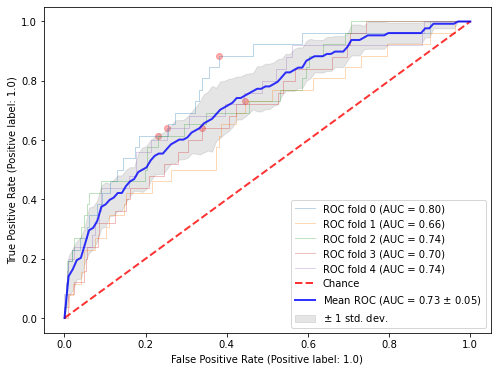

[0.7953725961538463, 0.6609074519230769, 0.7443659855769231, 0.7025, 0.741953125]
0.7290198317307693
========== Dog_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8633     ,    0.9545     ,    0.8702     ,    0.3652     ,    0.5283     
  0  ,    0.9476     ,    0.7727     ,    0.9343     ,    0.5484     ,    0.6415     
  1  ,    0.9174     ,    0.8444     ,    0.9118     ,    0.4634     ,    0.5984     
  1  ,    0.9456     ,    0.7556     ,    0.9308     ,    0.5397     ,    0.6296     
  2  ,    0.8499     ,    0.9111     ,    0.8547     ,    0.3388     ,    0.4940     
  2  ,    0.9550     ,    0.6889     ,    0.9343     ,    0.5636     ,    0.6200     
  3  ,    0.8124     ,    0.9778     ,    0.8253     ,    0.3056     ,    0.4656     
  3  ,    0.9493     ,    0.7333     ,    0.9325     ,    0.5500     ,    0.6286     
  4  ,    0.8630     ,    0.9111     ,    0.8668     ,    0.3596     ,    0.5157     
  4

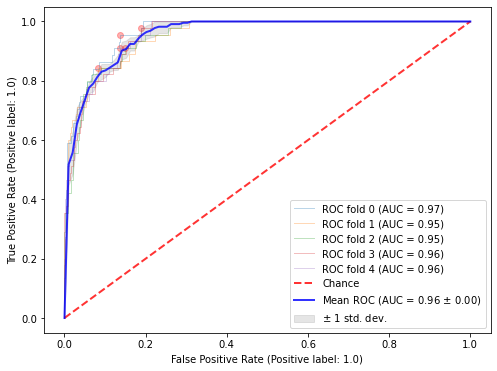

[0.9662070139598229, 0.9545132374400668, 0.9530122993537627, 0.9560975609756097, 0.9577235772357724]
0.9575107377930069
========== Dog_3_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9583     ,    0.8831     ,    0.9547     ,    0.5152     ,    0.6507     
  0  ,    0.9850     ,    0.7792     ,    0.9752     ,    0.7229     ,    0.7500     
  1  ,    0.9577     ,    0.8961     ,    0.9547     ,    0.5149     ,    0.6540     
  1  ,    0.9935     ,    0.7922     ,    0.9839     ,    0.8592     ,    0.8243     
  2  ,    0.9551     ,    0.8701     ,    0.9510     ,    0.4926     ,    0.6291     
  2  ,    0.9889     ,    0.7403     ,    0.9771     ,    0.7703     ,    0.7550     
  3  ,    0.8822     ,    0.9481     ,    0.8853     ,    0.2874     ,    0.4411     
  3  ,    0.9889     ,    0.6234     ,    0.9715     ,    0.7385     ,    0.6761     
  4  ,    0.9264     ,    0.8947     ,    0.9249     ,    0.3757     ,

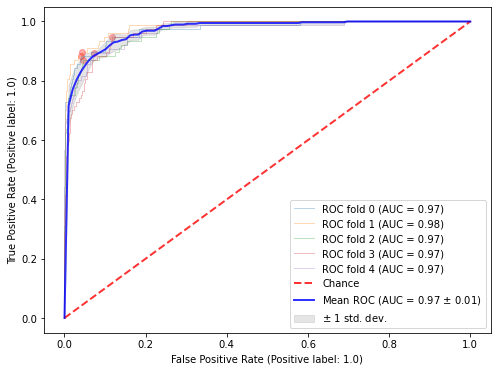

[0.9734256628787878, 0.9835548566017316, 0.9711005140692641, 0.9703649215367964, 0.966796875]
0.973048566017316
========== Dog_4_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.8730     ,    0.8846     ,    0.8742     ,    0.4577     ,    0.6033     
  0  ,    0.8834     ,    0.8365     ,    0.8784     ,    0.4652     ,    0.5979     
  1  ,    0.8287     ,    0.9038     ,    0.8368     ,    0.3900     ,    0.5449     
  1  ,    0.8893     ,    0.8077     ,    0.8805     ,    0.4693     ,    0.5936     
  2  ,    0.7751     ,    0.8558     ,    0.7838     ,    0.3156     ,    0.4611     
  2  ,    0.8974     ,    0.7115     ,    0.8773     ,    0.4568     ,    0.5564     
  3  ,    0.8471     ,    0.8269     ,    0.8450     ,    0.3963     ,    0.5358     
  3  ,    0.8716     ,    0.7788     ,    0.8616     ,    0.4241     ,    0.5492     
  4  ,    0.8378     ,    0.8750     ,    0.8418     ,    0.3957     ,    0.54

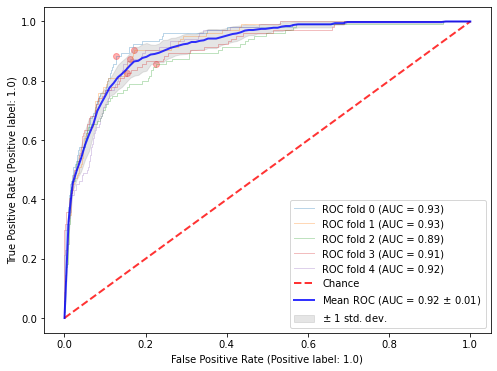

[0.9344069392146316, 0.9257665411511565, 0.8934350905504751, 0.9095233821021452, 0.919834395476169]
0.9165932696989156
========== Dog_5_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    0.9583     ,    0.9688     ,    0.9590     ,    0.6078     ,    0.7470     
  0  ,    0.9771     ,    0.9062     ,    0.9727     ,    0.7250     ,    0.8056     
  1  ,    0.9375     ,    1.0000     ,    0.9414     ,    0.5161     ,    0.6809     
  1  ,    0.9833     ,    0.8438     ,    0.9746     ,    0.7714     ,    0.8060     
  2  ,    0.9771     ,    1.0000     ,    0.9785     ,    0.7442     ,    0.8533     
  2  ,    0.9833     ,    0.9375     ,    0.9805     ,    0.7895     ,    0.8571     
  3  ,    0.9938     ,    1.0000     ,    0.9941     ,    0.9143     ,    0.9552     
  3  ,    0.9917     ,    1.0000     ,    0.9922     ,    0.8889     ,    0.9412     
  4  ,    0.9750     ,    1.0000     ,    0.9766     ,    0.7273     , 

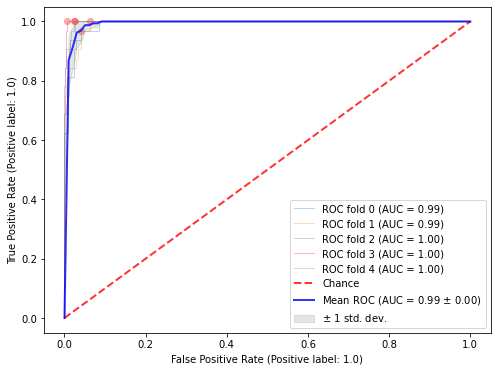

[0.9908203124999999, 0.9927083333333333, 0.9966145833333333, 0.9991536458333333, 0.9973958333333333]
0.9953385416666667
========== Patient_1_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  3  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000  

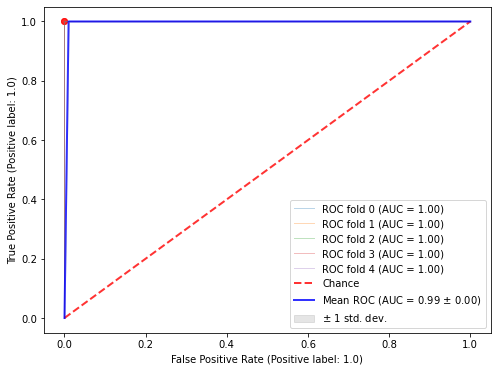

[1.0, 1.0, 1.0, 1.0, 1.0]
1.0
========== Patient_2_reduced ==========
fold ,  specificity  ,  sensitivity  ,   accuracy    ,      PPV      ,      f1       
  0  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  0  ,    1.0000     ,    0.9474     ,    0.9848     ,    1.0000     ,    0.9730     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  1  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  2  ,    1.0000     ,    0.9500     ,    0.9848     ,    1.0000     ,    0.9744     
  3  ,    0.9565     ,    1.0000     ,    0.9697     ,    0.9091     ,    0.9524     
  3  ,    0.9565     ,    0.9500     ,    0.9545     ,    0.9048     ,    0.9268     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     
  4  ,    1.0000     ,    1.0000     ,    1.0000     ,    1.0000     ,

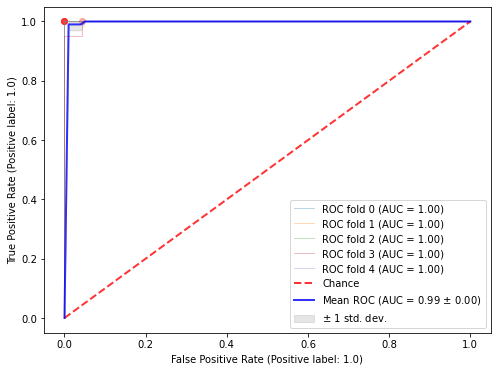

[1.0, 1.0, 1.0, 0.9978260869565218, 1.0]
0.9995652173913043


In [8]:
file_list = [f for f in Path(pred_path).glob("*_reduced.csv")]
for f in file_list:
    data = pd.read_csv(f.resolve())
    sample = f.name.split('.')[0]
    print('='*10, sample ,'='*10)
    data_y = data["result"].to_numpy()
    data_x = data.loc[:, data.columns != 'result'].to_numpy()
    aucs = train_pred(data_x, data_y,save=sample)
    print(aucs)
    print(np.mean(aucs))